In [1]:
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

import catboost as cb
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv('assignment_2_train.csv')
test = pd.read_csv('assignment_2_test.csv')

In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print("train.shape = {} rows, {} cols".format(*train.shape))

train.shape = 180000 rows, 394 cols


In [5]:
target = train['isFraud']
train = train.drop(['isFraud', 'TransactionID'], axis=1)

**Задание 1:** отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [6]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 378


Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=378)

In [7]:
x_train, x_valid = train_test_split(
    numerical_features, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols


In [8]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [9]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [10]:
model_xgb_nf = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=50,
    maximize=True,
)

[12:53:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64988	valid-auc:0.65040
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.88183	valid-auc:0.87420
[100]	train-auc:0.90013	valid-auc:0.88967
[150]	train-auc:0.90824	valid-auc:0.89758
[200]	train-auc:0.91004	valid-auc:0.89892
Stopping. Best iteration:
[167]	train-auc:0.91004	valid-auc:0.89892



**Задание 2:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [11]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)

Categorical Feature Count 14


,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [12]:
for cat_colname in train.select_dtypes(include='object').columns[1:]:
    train_cat = pd.concat([train, pd.get_dummies(train[cat_colname], prefix=cat_colname)], axis=1)

In [13]:
train_cat.head(2)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V332,V333,V334,V335,V336,V337,V338,V339,M9_F,M9_T
0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [14]:
train_cat.shape

(180000, 394)

In [15]:
train_cat = train_cat.drop(categorical_features.columns, axis=1)

In [16]:
train_cat.shape

(180000, 380)

In [17]:
x_train, x_valid = train_test_split(
    train_cat, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 380 cols
x_valid.shape = 36000 rows, 380 cols


In [18]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [19]:
model_xgb_cf = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=50,
    maximize=True,
)

[12:54:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64988	valid-auc:0.65040
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.88183	valid-auc:0.87420
[100]	train-auc:0.90013	valid-auc:0.88967
[150]	train-auc:0.90824	valid-auc:0.89758
[200]	train-auc:0.91216	valid-auc:0.90080
Stopping. Best iteration:
[190]	train-auc:0.91216	valid-auc:0.90080



**Задание 4:** для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [20]:
x_train, x_valid = train_test_split(
    numerical_features, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)

In [21]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

In [22]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

In [23]:
model_lgbm_nf = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=250
)

[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31591
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 376
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.918873	valid_1's auc: 0.900764
[500]	training's auc: 0.944222	valid_1's auc: 0.919666
[750]	training's auc: 0.956513	valid_1's auc: 0.928522
[1000]	training's auc: 0.96491	valid_1's auc: 0.93473
[1250]	training's auc: 0.971182	valid_1's auc: 0.93837
[1500]	training's auc: 0.976402	valid_1's auc: 0.941549
[1750]	training'

**Задание 5:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [24]:
x_train, x_valid = train_test_split(
    train_cat, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)

In [25]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

In [26]:
model_lgbm_cf = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=250
)

[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31595
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 378
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.918873	valid_1's auc: 0.900764
[500]	training's auc: 0.944179	valid_1's auc: 0.919481
[750]	training's auc: 0.956511	valid_1's auc: 0.929131
[1000]	training's auc: 0.965255	valid_1's auc: 0.935059
[1250]	training's auc: 0.971172	valid_1's auc: 0.938889
[1500]	training's auc: 0.976302	valid_1's auc: 0.941838
[1750]	traini

**Задание 6:** обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [27]:
train_cat_cat = train.copy()

In [28]:
for c in categorical_features:
    train_cat_cat[c] = train_cat_cat[c].astype('category')

In [29]:
x_train, x_valid = train_test_split(
    train_cat_cat, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)

In [30]:
cat_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [31]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train, categorical_feature = cat_features
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid, categorical_feature = cat_features
)

In [32]:
model_lgbm_cat = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature=cat_features,
    early_stopping_rounds=50,
    verbose_eval=250
)

[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31755
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 390
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.926908	valid_1's auc: 0.909239
[500]	training's auc: 0.951757	valid_1's auc: 0.927188
[750]	training's auc: 0.964871	valid_1's auc: 0.936713
[1000]	training's auc: 0.972807	valid_1's auc: 0.94183
[1250]	training's auc: 0.978737	valid_1's auc: 0.945283
[1500]	training's auc: 0.983219	valid_1's auc: 0.948374
[1750]	trainin

При обработке категорий встроенным методом, качество обучения выше на 0,002 на трейне и 0,004 на вылидации

**Задание 7:** для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [33]:
x_train, x_valid = train_test_split(
    numerical_features, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
train_pool = cb.Pool(x_train, y_train)
valid_pool = cb.Pool(x_valid, y_valid)

In [34]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 200,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [35]:
model_cat_nf = cb.CatBoostClassifier(**cb_params)
model_cat_nf.fit(train_pool, eval_set=valid_pool)

0:	test: 0.5988007	best: 0.5988007 (0)	total: 121ms	remaining: 20m 9s
200:	test: 0.8722220	best: 0.8722220 (200)	total: 12.7s	remaining: 10m 18s
400:	test: 0.8839140	best: 0.8839140 (400)	total: 25.2s	remaining: 10m 4s
600:	test: 0.8854287	best: 0.8854292 (597)	total: 36.5s	remaining: 9m 30s
800:	test: 0.8859115	best: 0.8859124 (794)	total: 47.6s	remaining: 9m 6s
1000:	test: 0.8876637	best: 0.8876637 (1000)	total: 59.1s	remaining: 8m 51s
1200:	test: 0.8904952	best: 0.8904952 (1200)	total: 1m 11s	remaining: 8m 40s
1400:	test: 0.8912365	best: 0.8912365 (1400)	total: 1m 22s	remaining: 8m 26s
1600:	test: 0.8931860	best: 0.8931860 (1600)	total: 1m 34s	remaining: 8m 13s
1800:	test: 0.8961684	best: 0.8961684 (1800)	total: 1m 46s	remaining: 8m 2s
2000:	test: 0.8981880	best: 0.8981880 (2000)	total: 1m 57s	remaining: 7m 51s
2200:	test: 0.9001578	best: 0.9001578 (2200)	total: 2m 9s	remaining: 7m 38s
2400:	test: 0.9017867	best: 0.9017867 (2400)	total: 2m 20s	remaining: 7m 25s
2600:	test: 0.9034171

In [36]:
x_train, x_valid = train_test_split(
    train_cat, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)

train_pool = cb.Pool(x_train, y_train)
valid_pool = cb.Pool(x_valid, y_valid)

In [37]:
model_cat_cf = cb.CatBoostClassifier(**cb_params)
model_cat_cf.fit(train_pool, eval_set=valid_pool)

0:	test: 0.6942472	best: 0.6942472 (0)	total: 67.6ms	remaining: 11m 16s
200:	test: 0.8707715	best: 0.8707715 (200)	total: 12.5s	remaining: 10m 7s
400:	test: 0.8829223	best: 0.8829223 (400)	total: 24.6s	remaining: 9m 50s
600:	test: 0.8842564	best: 0.8842564 (600)	total: 35.9s	remaining: 9m 21s
800:	test: 0.8845393	best: 0.8845393 (800)	total: 46.7s	remaining: 8m 56s
1000:	test: 0.8880775	best: 0.8880775 (1000)	total: 58.2s	remaining: 8m 43s
1200:	test: 0.8897252	best: 0.8897252 (1200)	total: 1m 9s	remaining: 8m 27s
1400:	test: 0.8917493	best: 0.8917532 (1398)	total: 1m 20s	remaining: 8m 12s
1600:	test: 0.8929125	best: 0.8929125 (1600)	total: 1m 31s	remaining: 7m 59s
1800:	test: 0.8956452	best: 0.8956454 (1799)	total: 1m 42s	remaining: 7m 47s
2000:	test: 0.8974902	best: 0.8974902 (2000)	total: 1m 54s	remaining: 7m 36s
2200:	test: 0.8997221	best: 0.8997221 (2200)	total: 2m 5s	remaining: 7m 26s
2400:	test: 0.9009615	best: 0.9009615 (2400)	total: 2m 17s	remaining: 7m 14s
2600:	test: 0.90261

**Задание 9:** обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [38]:
train_cat_str = train.copy()

In [39]:
for c in categorical_features:
    train_cat_str[c] = train_cat_str[c].astype('str')

In [40]:
x_train, x_valid = train_test_split(
    train_cat_str, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)


train_pool = cb.Pool(x_train, y_train, cat_features = cat_features)
valid_pool = cb.Pool(x_valid, y_valid, cat_features = cat_features)

In [41]:
model_cat_cat = cb.CatBoostClassifier(**cb_params)
model_cat_cat.fit(train_pool, eval_set=valid_pool)

0:	test: 0.7531850	best: 0.7531850 (0)	total: 266ms	remaining: 44m 20s
200:	test: 0.8773895	best: 0.8773895 (200)	total: 44.7s	remaining: 36m 21s
400:	test: 0.8891383	best: 0.8891383 (400)	total: 1m 28s	remaining: 35m 16s
600:	test: 0.8923420	best: 0.8923460 (568)	total: 2m 11s	remaining: 34m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8923460154
bestIteration = 568

Shrink model to first 569 iterations.


Модель показала результат лучше на предобработанных категориях

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [42]:
test_target = test['isFraud']
test = test.drop(['isFraud', 'TransactionID'], axis=1)

test_numerical_features = test.select_dtypes(include=[np.number])

categorical_features = train.select_dtypes(include=[np.object])

for cat_colname in test.select_dtypes(include='object').columns[1:]:
    test_cat = pd.concat([test, pd.get_dummies(test[cat_colname], prefix=cat_colname)], axis=1)

test_cat = test_cat.drop(categorical_features.columns, axis=1)

test_cat_cat = test.copy()

for c in categorical_features:
    test_cat_cat[c] = test_cat_cat[c].astype('category')
    

test_cat_str = train.copy()

for c in categorical_features:
    test_cat_str[c] = test_cat_str[c].astype('str')
    
    

In [43]:
test_xgb_nf = xgb.DMatrix(data=test_numerical_features)
test_xgb_nf

In [44]:
test_xgb_nf = xgb.DMatrix(data=test_numerical_features)
test_xgb_cf = xgb.DMatrix(data=test_cat)

test_lgbm_nf = lgb.Dataset(test_numerical_features)
test_lgbm_cf = lgb.Dataset(test_cat)
test_lgbm_nf = lgb.Dataset(test_cat_cat, categorical_feature = cat_features)

test_cat_nf = cb.Pool(test_numerical_features)
test_cat_cf = cb.Pool(test_cat)
test_cat_cat = cb.Pool(test_cat_str, cat_features = cat_features)

TypeError: Cannot use Dataset instance for prediction, please use raw data instead

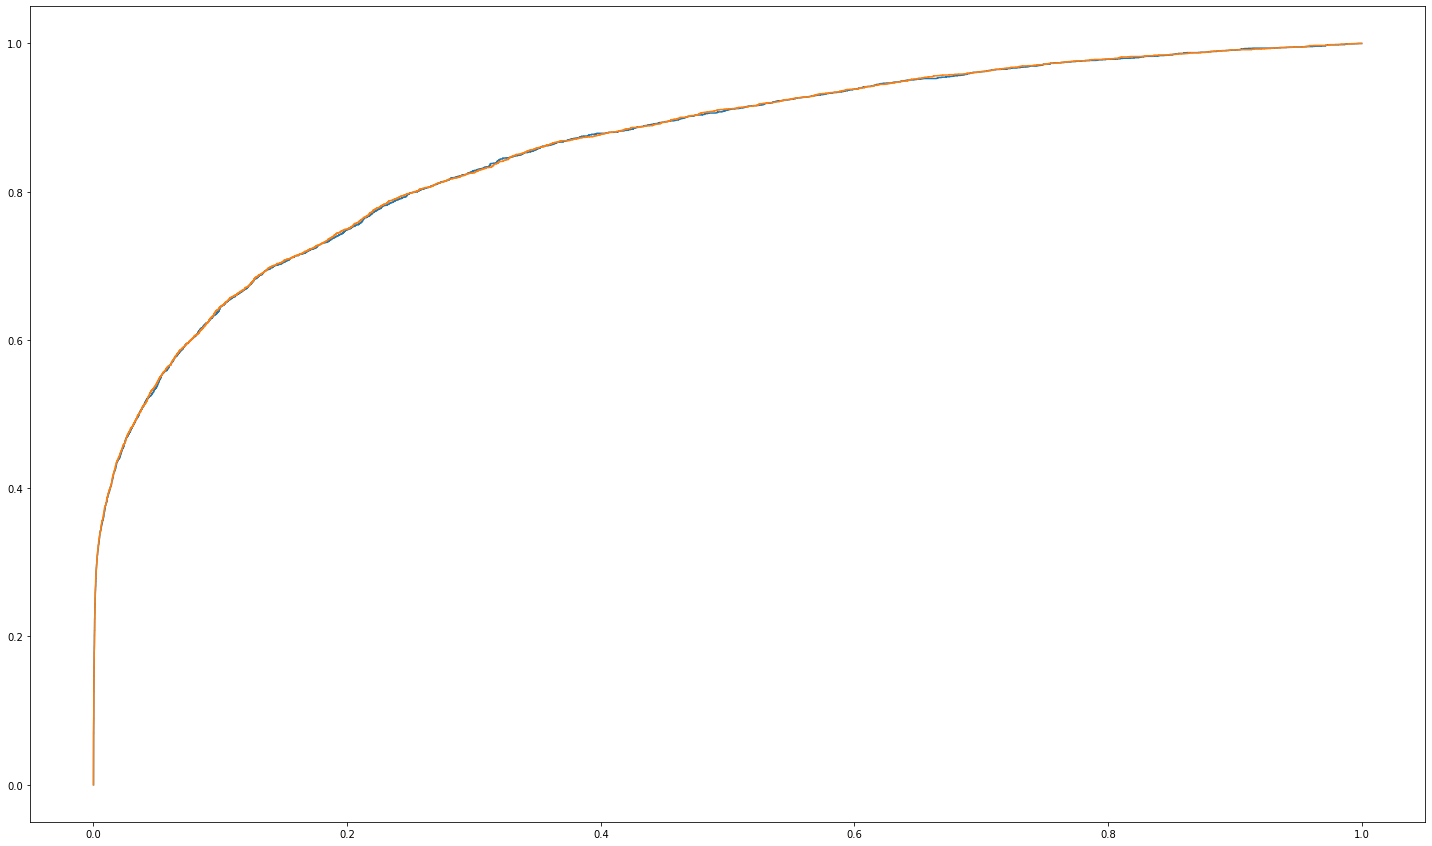

<Figure size 1800x1080 with 0 Axes>

In [45]:
fig = plt.figure(figsize=(25, 15))

pred = model_xgb_nf.predict(test_xgb_nf)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_xgb_num (area = %0.6f)' % roc_auc)

pred = model_xgb_cf.predict(test_xgb_cf)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='dtest_xgb_num_cat (area = %0.6f)' % roc_auc)

fig = plt.figure(figsize=(25, 15))

pred = model_lgbm_nf.predict(test_lgbm_nf)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgbm_num (area = %0.6f)' % roc_auc)


pred = model_cat_nf.predict(test_cat_nf)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_cat_num (area = %0.6f)' % roc_auc)

pred = model_cat_cf.predict(test_cat_cf)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_cat_cat (area = %0.6f)' % roc_auc)

pred = model_cat_cat.predict(test_cat_cat)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_cat_categorical (area = %0.6f)' % roc_auc)


pred = model_lgbm_cf.predict(test_lgbm_cf)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgbm_cat (area = %0.6f)' % roc_auc)

pred = model_lgbm_cat.predict(test_lgbm_cat)
fpr, tpr, _ = roc_curve(test_target, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='test_lgbm_categorical (area = %0.6f)' % roc_auc)




plt.plot([0, 1], [0, 1], color='red', linestyle='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()